## Setup

In [44]:
import pandas as pd
from pprint import pprint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mapbox import Geocoder
import os
from dotenv import load_dotenv
import json
from dataclasses import dataclass,  fields, _MISSING_TYPE
import requests


## Data Ingestion

In [45]:
address_df = pd.read_csv(r"data\raw\address.csv")

## Using Mapbox geocoding api

Trying for one address only

In [7]:
load_dotenv()
API_KEY = os.getenv('API_KEY')
geocoder = Geocoder(access_token= API_KEY)

address_geocodes  = []
address = address_df["address"][0]
print(f"Address in my data: {address}\n----------")

response = geocoder.forward(address).json()
print(f"Response received: \n")
pprint(response)
print(f"\n--------")

address_geocode = {'address': address,
'place_name': response["features"][0]["place_name"],
    'relevance': response["features"][0]["relevance"],
    'bbox': response["features"][0]["bbox"],
    'longitude': response["features"][0]["center"][0],
    'lattitude': response["features"][0]["center"][1]

    }
address_geocodes.append(address_geocode)

print(f"keeping the essential values, we get,")
pprint(address_geocode)
pprint(address_geocodes)

df = pd.DataFrame(address_geocodes)

print(df)


Address in my data: Electronic City Phase II,Bangalore,Karnataka,India
----------


Response received: 

{'attribution': 'NOTICE: © 2023 Mapbox and its suppliers. All rights reserved. '
                'Use of this data is subject to the Mapbox Terms of Service '
                '(https://www.mapbox.com/about/maps/). This response and the '
                'information it contains may not be retained. POI(s) provided '
                'by Foursquare.',
 'features': [{'bbox': [77.6712864, 12.83594, 77.692464, 12.8537642],
               'center': [77.680811, 12.843526],
               'context': [{'id': 'postcode.83873387',
                            'mapbox_id': 'dXJuOm1ieHBsYzpCUC9PYXc',
                            'text': '560100'},
                           {'id': 'locality.1297181291',
                            'mapbox_id': 'dXJuOm1ieHBsYzpUVkZxYXc',
                            'text': 'Electronic City'},
                           {'id': 'place.5212267',
                            'mapbox_id': 'dXJuOm1ieHBsYzpUNGhy',
                            'text': 'Beng

Geoencoding all the addresses

In [8]:
load_dotenv()
API_KEY = os.getenv('API_KEY')
geocoder = Geocoder(access_token= API_KEY)

address_geocodes  = []

for address in address_df.address:
    response = geocoder.forward(address).json()

    address_geocode = {'address': address,
    'place_name': response["features"][0]["place_name"],
        'relevance': response["features"][0]["relevance"],
        'longitude': response["features"][0]["center"][0],
        'lattitude': response["features"][0]["center"][1]

        }
    address_geocodes.append(address_geocode)

df = pd.DataFrame(address_geocodes)


Checking how our dataframe looks like now

In [46]:
df

,address,place_name,relevance,longitude,latitude
0,"Lingadheeranahalli,Bangalore,Karnataka,India",NOT_FOUND,0,None,None


Exporting the file containing all the geoencoded data so that we do not have to wait for geoencoding every time

In [10]:
file_path = r'data\processed/'
file_name = "addresses_gecoded_by_mapboxAPI.csv"
extract_info = file_path + file_name
df.to_csv(extract_info, index=False)

## EDA on Mapbox geocoded data

Data ingestion of the geo-encoded file

In [47]:
df = pd.read_csv(r"data\processed\addresses_gecoded_by_mapboxAPI.csv")

Finding all the rows where latitude and longitude point to the general location of Bangalore only

In [48]:
inaccurate_df = df.loc[(df['longitude'] == 77.591300) & (df['lattitude'] == 12.979120)]

Plotting distribution of relevance, longitude and latitude 

Text(0.5, 1.0, 'Histplot for Relevance')

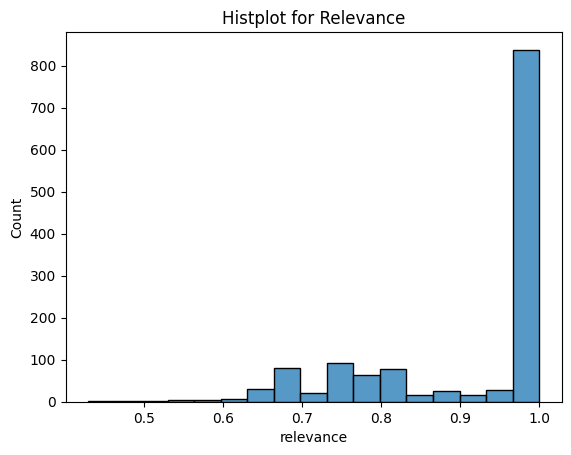

In [13]:
sns.histplot(df.relevance)
plt.title("Histplot for Relevance")

Text(0.5, 1.0, 'Histplot for Longitude')

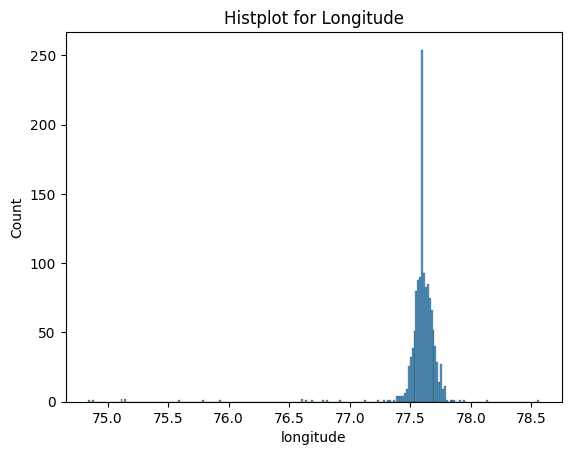

In [14]:
sns.histplot(df.longitude)
plt.title("Histplot for Longitude")

Text(0.5, 1.0, 'Histplot for Lattitude')

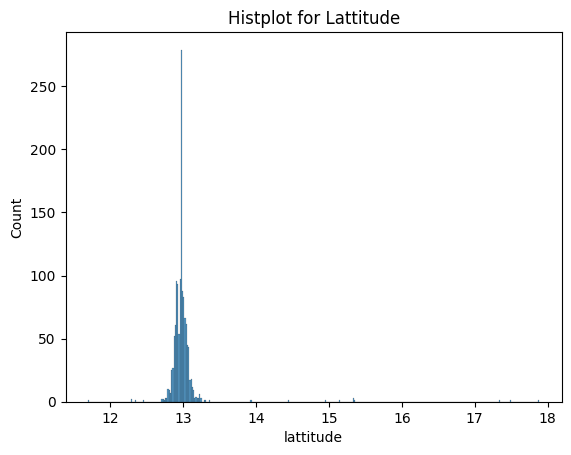

In [15]:
sns.histplot(df.lattitude)
plt.title("Histplot for Lattitude")

Plotting longitude and latitude using scatterplot

Text(0, 0.5, 'latitude')

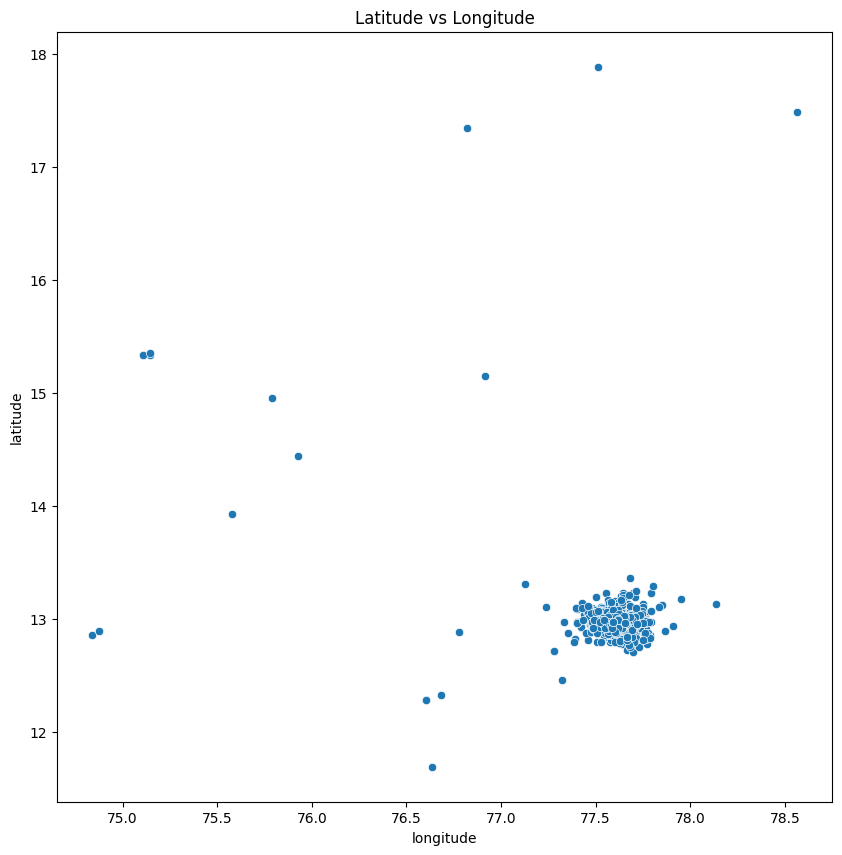

In [16]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= df.longitude, y=df.lattitude)
plt.title('Latitude vs Longitude')
plt.ylabel('latitude')

## Using https://geocode.maps.co/ free api

Created a dataclass to skip errors where the api does not have the data for our given address

In [17]:
@dataclass
class GeocodedAddress:
    address: str
    place_name: str = 'NOT_FOUND' 
    relevance: float = 0
    longitude: float = None
    latitude: float = None

    def __post_init__(self):
        # Loop through the fields
        for field in fields(self):
            # If there is a default and the value of the field is none we can assign a value
            if not isinstance(field.default, _MISSING_TYPE) and getattr(self, field.name) is None:
                setattr(self, field.name, field.default)

Trying for one address only

In [18]:
address_geocodes  = []
address = address_df["address"][3]
print(f"Address in my data: {address}\n----------")

geocode_base_url = f"https://geocode.maps.co/search?q={address}"
response = requests.get(geocode_base_url).json()
print(f"Response received: \n")
pprint(response)
print(f"\n--------")


if len(response) >=1:

    address_geocode = GeocodedAddress(
        address=address,
        place_name = response[0]["display_name"],
        relevance = response[0]["importance"],
        longitude = response[0]["lon"],
        latitude = response[0]["lat"]
    )
else: 
    address_geocode = GeocodedAddress(
        address=address
    )

    address_geocodes.append(address_geocode.__dict__)

    print(f"keeping the essential values, we get,")
    pprint(address_geocode)
    pprint(address_geocodes)

    df = pd.DataFrame(address_geocodes)

    print(df)


Address in my data: Lingadheeranahalli,Bangalore,Karnataka,India
----------
Response received: 

[]

--------
keeping the essential values, we get,
GeocodedAddress(address='Lingadheeranahalli,Bangalore,Karnataka,India', place_name='NOT_FOUND', relevance=0, longitude=None, latitude=None)
[{'address': 'Lingadheeranahalli,Bangalore,Karnataka,India',
  'latitude': None,
  'longitude': None,
  'place_name': 'NOT_FOUND',
  'relevance': 0}]
                                        address place_name  relevance  \
0  Lingadheeranahalli,Bangalore,Karnataka,India  NOT_FOUND          0   

  longitude latitude  
0      None     None  


Geoencoding for all the addresses

In [19]:
address_geocodes  = []

for address in address_df.address:
    print(address)
    geocode_base_url = f"https://geocode.maps.co/search?q={address}"
    response = requests.get(geocode_base_url).json()

    if len(response) >=1:

        address_geocode = GeocodedAddress(
            address=address,
            place_name = response[0]["display_name"],
            relevance = response[0]["importance"],
            longitude = response[0]["lon"],
            latitude = response[0]["lat"]
        )
    else: 
        address_geocode = GeocodedAddress(
            address=address
        )

    address_geocodes.append(address_geocode.__dict__)


geocode_map_df = pd.DataFrame(address_geocodes)

Electronic City Phase II,Bangalore,Karnataka,India
Chikka Tirupathi,Bangalore,Karnataka,India
Uttarahalli,Bangalore,Karnataka,India
Lingadheeranahalli,Bangalore,Karnataka,India
Kothanur,Bangalore,Karnataka,India
Whitefield,Bangalore,Karnataka,India
Old Airport Road,Bangalore,Karnataka,India
Rajaji Nagar,Bangalore,Karnataka,India
Marathahalli,Bangalore,Karnataka,India
Gandhi Bazar,Bangalore,Karnataka,India
7th Phase JP Nagar,Bangalore,Karnataka,India
Gottigere,Bangalore,Karnataka,India
Sarjapur,Bangalore,Karnataka,India
Mysore Road,Bangalore,Karnataka,India
Bisuvanahalli,Bangalore,Karnataka,India
Raja Rajeshwari Nagar,Bangalore,Karnataka,India
Ramakrishnappa Layout,Bangalore,Karnataka,India
Manayata Tech Park,Bangalore,Karnataka,India
Kengeri,Bangalore,Karnataka,India
Binny Pete,Bangalore,Karnataka,India
Thanisandra,Bangalore,Karnataka,India
Bellandur,Bangalore,Karnataka,India
 Thanisandra,Bangalore,Karnataka,India
Mangammanapalya,Bangalore,Karnataka,India
Electronic City,Bangalore,Karn

Exporting the file containing all the geoencoded data so that we do not have to wait for geoencoding every time

In [20]:
file_path = r'data\processed/'
file_name = "addresses_geocoded_by_geocodemaps.csv"
extract_info = file_path + file_name
geocode_map_df.to_csv(extract_info, index=False)

## EDA on geocode.map.co geocoded data

Data ingestion on the geoencoded file

In [49]:
geocode_map_df = pd.read_csv(r"data\processed\addresses_geocoded_by_geocodemaps.csv")

Checking how our dataframe looks like 

In [50]:
geocode_map_df

,address,place_name,relevance,longitude,latitude
0,"Electronic City Phase II,Bangalore,Karnataka,I...","Electronics City Phase 2 (West), Anekal, Banga...",0.895,77.672524,12.837158
1,"Chikka Tirupathi,Bangalore,Karnataka,India","Chikka Tirupathi, Dabaspete - Hosur Highway, C...",0.421,77.867101,12.895768
2,"Uttarahalli,Bangalore,Karnataka,India","Uttarahalli, Bommanahalli Zone, Bengaluru, Ban...",0.680,77.545544,12.905568
3,"Lingadheeranahalli,Bangalore,Karnataka,India",NOT_FOUND,0.000,NaN,NaN
4,"Kothanur,Bangalore,Karnataka,India","Kothanur, Horamavu, Mahadevapura Zone, Bengalu...",0.705,77.649389,13.061360
...,...,...,...,...,...
1300,"Pattegarhpalya,Bangalore,Karnataka,India",NOT_FOUND,0.000,NaN,NaN
1301,"Tilak Nagar,Bangalore,Karnataka,India","Tilak Nagar, Byrasandra Ward, South Zone, Beng...",0.770,77.594712,12.927588
1302,12th cross srinivas nagar banshankari 3rd stag...,NOT_FOUND,0.000,NaN,NaN
1303,"Havanur extension,Bangalore,Karnataka,India",NOT_FOUND,0.000,NaN,NaN


Finding all the rows where place_name is NOT_FOUND

In [51]:
not_found_df = geocode_map_df.loc[geocode_map_df['place_name'] == 'NOT_FOUND']

Plotting distribution of relevance, longitude and latitude

Text(0.5, 1.0, 'Histplot for Relevance')

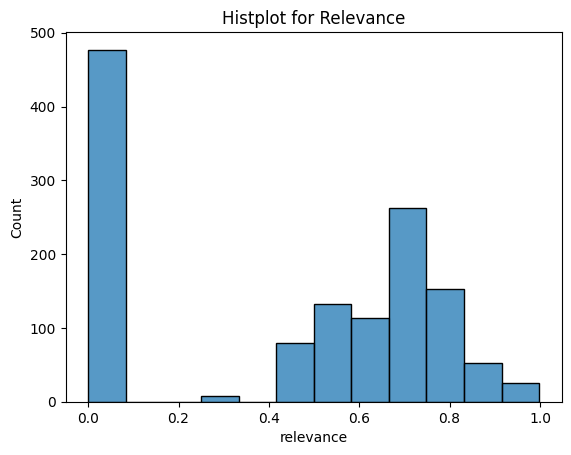

In [24]:
sns.histplot(geocode_map_df.relevance)
plt.title("Histplot for Relevance")

Text(0.5, 1.0, 'Histplot for Longitude')

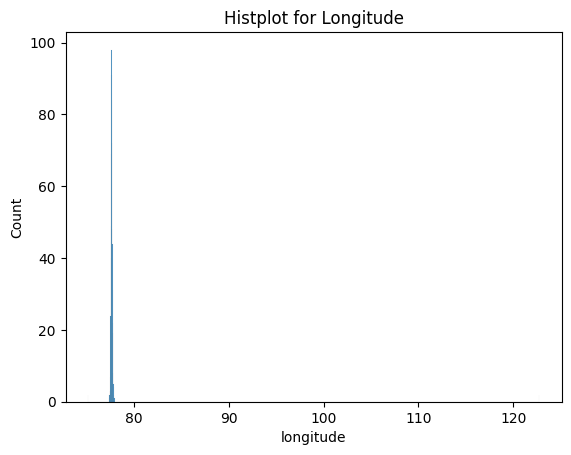

In [25]:
sns.histplot(geocode_map_df.longitude)
plt.title("Histplot for Longitude")

Text(0.5, 1.0, 'Histplot for Latitude')

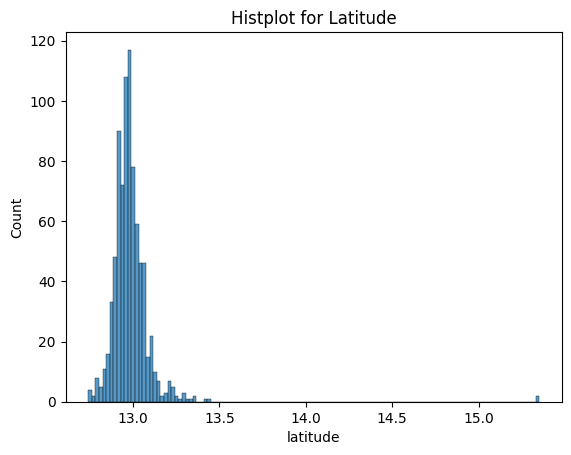

In [26]:
sns.histplot(geocode_map_df.latitude)
plt.title("Histplot for Latitude")

Plotting longitude and latitude using scatterplot

Text(0.5, 1.0, 'Latitude vs Longitude')

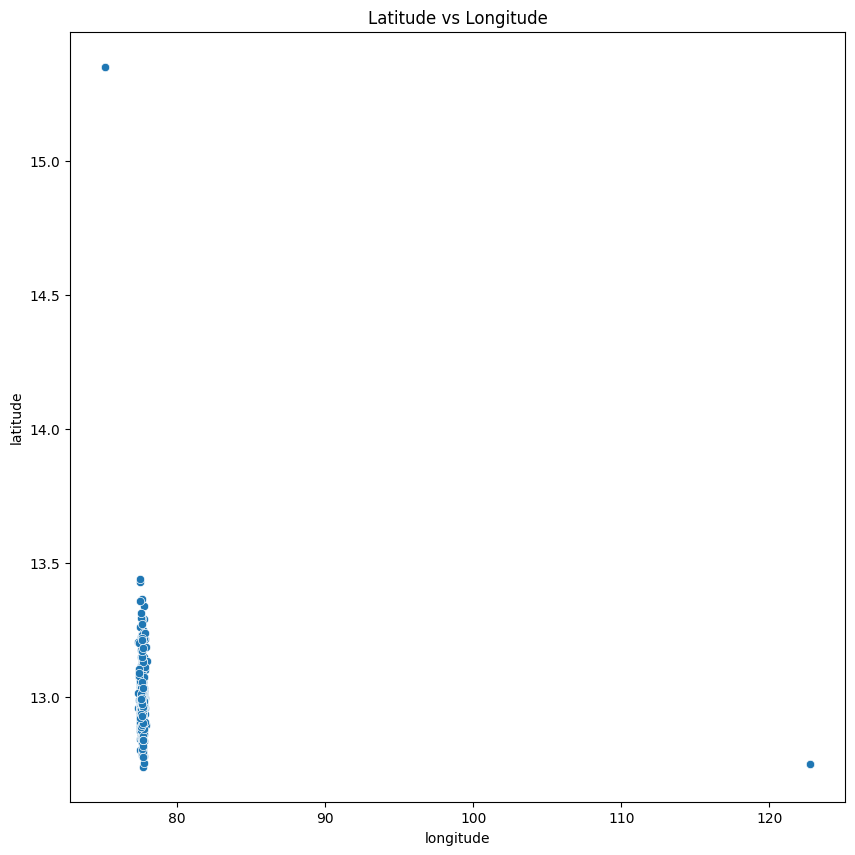

In [27]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= geocode_map_df.longitude, y=geocode_map_df.latitude)
plt.title('Latitude vs Longitude')

We used 2 geoencoding APIs mapbox and geocode.maps.co from the analysis above it is clear that the encoding by mapbox is far more efficient than by geocode.map url. We see from the not found columns that the url has 477 addresses not available where as mapbox only had 154.
Furthermore with the columns that it did found mapbox has a relevance of 1 with most addresses, which means being able to encode the exact address we want where it is very less in case of the url, which is also showcased while plotting the scatterplot.

## Merging the 2 dataframes for better results 

Extracting only the address from our data with multiple longitude and latitude taken as the general bangalore coordinates

In [52]:
addr_inaccurate_df = inaccurate_df['address']

Merged the address column with the geocode url encoded data to get accurate coordinates in place of the general coordinates

In [53]:
merged_df = pd.merge(addr_inaccurate_df,geocode_map_df)

Checking how many of them are found and creating a dataframe for it

In [55]:
found_df = merged_df.loc[merged_df['place_name']!='NOT_FOUND']
found_df.shape[0]

54

We see that 54 rows now have better coordinates than the general bangalore coordinates, and we now move on to put them in our original df 

In [56]:
# Set the index of found_df to be the address column
found_df.set_index('address', inplace=True)

# Iterate through the rows of df and update the longitude and latitude values
for index, row in df.iterrows():
    address = row['address']
    if address in found_df.index:
        df.at[index, 'place_name'] = found_df.at[address, 'place_name']
        df.at[index, 'longitude'] = found_df.at[address, 'longitude']
        df.at[index, 'lattitude'] = found_df.at[address, 'latitude']

# Reset the index to bring the DataFrame back to its original format
df.reset_index(drop=True, inplace=True)


Conducting Sanity Checks

In [57]:
df

,address,place_name,relevance,longitude,lattitude
0,"Electronic City Phase II,Bangalore,Karnataka,I...","Electronic City Phase II, Electronic City, Ben...",1.000000,77.680811,12.843526
1,"Chikka Tirupathi,Bangalore,Karnataka,India","Chikka Tirupathi Temple, NH 207, Malur, Karnat...",0.818222,77.865734,12.895305
2,"Uttarahalli,Bangalore,Karnataka,India","Uttarahalli, Bommanahalli Zone, Bengaluru, Ban...",0.750000,77.545544,12.905568
3,"Lingadheeranahalli,Bangalore,Karnataka,India","Lingadheeranahalli, Bengaluru, Bengaluru Urban...",1.000000,77.541279,12.880725
4,"Kothanur,Bangalore,Karnataka,India","Kothanur, Bengaluru, Bengaluru Urban, Karnatak...",1.000000,77.649389,13.061360
...,...,...,...,...,...
1300,"Pattegarhpalya,Bangalore,Karnataka,India","Pattegarhpalya, Vijayanagar, Bengaluru, Bengal...",1.000000,77.522444,12.977787
1301,"Tilak Nagar,Bangalore,Karnataka,India","Tilak Nagar, Tilak Nagar, Bengaluru, Karnataka...",1.000000,77.588115,12.922427
1302,12th cross srinivas nagar banshankari 3rd stag...,"3rd Stage, Basaveshwar Nagar, Bengaluru, Benga...",0.676667,77.542156,12.989875
1303,"Havanur extension,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.683333,77.591300,12.979120


In [59]:
df.loc[(df['longitude'] == 77.591300) & (df['lattitude'] == 12.979120)]

,address,place_name,relevance,longitude,lattitude
19,"Binny Pete,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.683333,77.5913,12.97912
69,"Devasthanagalu,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.750000,77.5913,12.97912
113,"CHIKKATIRUPATHI,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.750000,77.5913,12.97912
144,"Dr Shivarama Karantha Nagar,Bangalore,Karnatak...","Bengaluru, Karnataka, India",0.607143,77.5913,12.97912
146,"Kullappa Colony,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.683333,77.5913,12.97912
...,...,...,...,...,...
1280,"Chikbasavanapura,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.750000,77.5913,12.97912
1282,"Chuchangatta Colony,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.683333,77.5913,12.97912
1287,"Doddanakunte,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.750000,77.5913,12.97912
1292,"Chellikere,Bangalore,Karnataka,India","Bengaluru, Karnataka, India",0.750000,77.5913,12.97912


## Final geoencoded data 

Text(0, 0.5, 'latitude')

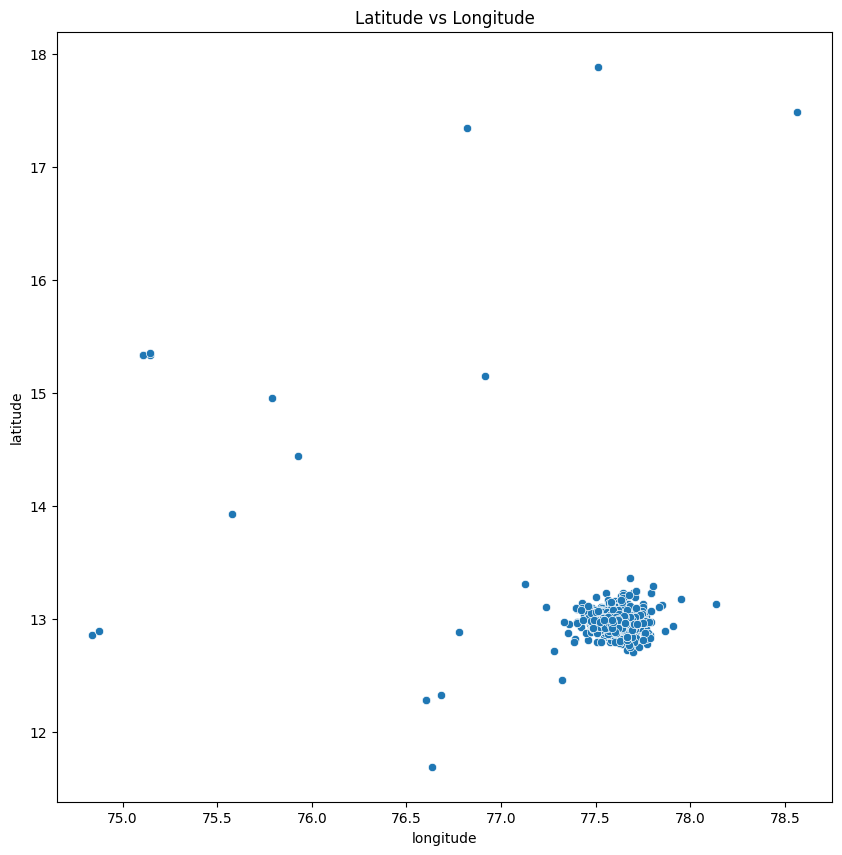

In [61]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= df.longitude, y=df.lattitude)
plt.title('Latitude vs Longitude')
plt.ylabel('latitude')

Extracting this dataframe now as it is better than our original encoded datasets.

In [37]:
file_path = r'data\final/'
file_name = "encoded_addr.csv"
extract_info = file_path + file_name
geocode_map_df.to_csv(extract_info, index=False)